# Multivariate Time Series Forecasting

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

## Wind Speed Prediction Dataset

Source of dataset: https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset


Attribute Information

DATE (YYYY-MM-DD)

WIND: Average wind speed [knots]

IND: First indicator value

RAIN: Precipitation Amount (mm)

IND.1: Second indicator value

T.MAX: Maximum Temperature (°C)

IND.2: Third indicator value

T.MIN: Minimum Temperature (°C)

T.MIN.G: 09utc Grass Minimum Temperature (°C)

fedesoriano. (April 2022). Wind Speed Prediction Dataset. Retrieved [8-03-2024] from https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset

In [2]:
dataset=pd.read_csv(r"C:\Users\Itisha Sharma\Desktop\GitHub\Python_DL_GRU_Timeseries\wind_dataset.csv")
dataset.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [3]:
dataset.isnull().sum()

DATE         0
WIND         0
IND          0
RAIN         0
IND.1       61
T.MAX      621
IND.2       61
T.MIN      674
T.MIN.G    360
dtype: int64

In [4]:
dataset=dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5638 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     5638 non-null   object 
 1   WIND     5638 non-null   float64
 2   IND      5638 non-null   int64  
 3   RAIN     5638 non-null   float64
 4   IND.1    5638 non-null   float64
 5   T.MAX    5638 non-null   float64
 6   IND.2    5638 non-null   float64
 7   T.MIN    5638 non-null   float64
 8   T.MIN.G  5638 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 440.5+ KB


In [5]:
dataset.shape

(5638, 9)

In [6]:
dataset['DATE']=pd.to_datetime(dataset['DATE'])
dataset.set_index('DATE', inplace=True)
dataset.dtypes

WIND       float64
IND          int64
RAIN       float64
IND.1      float64
T.MAX      float64
IND.2      float64
T.MIN      float64
T.MIN.G    float64
dtype: object

## Dataset preparation

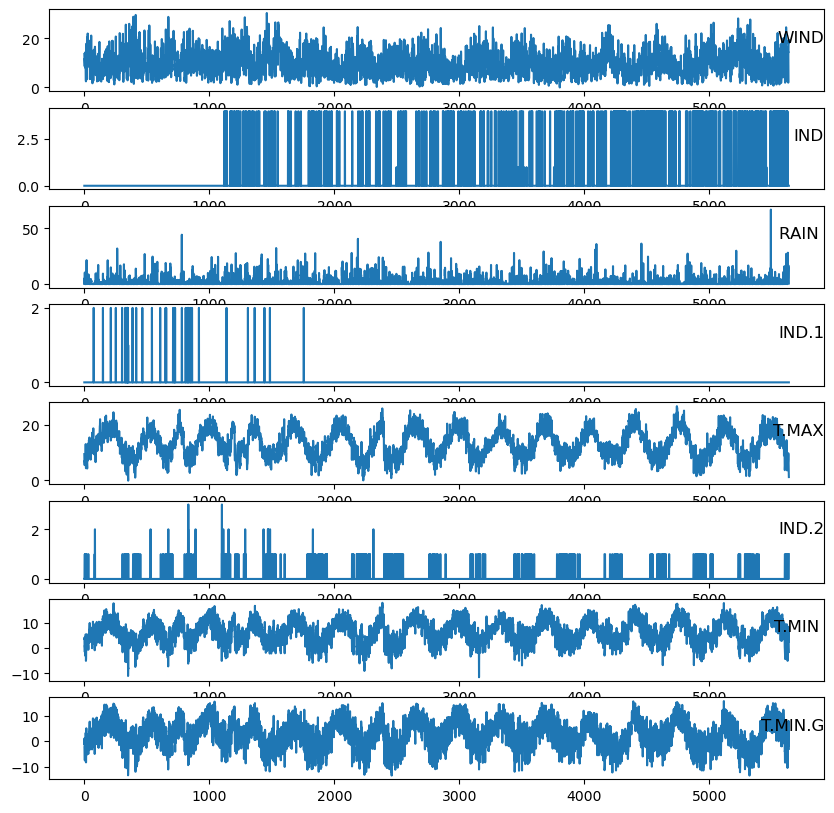

In [7]:
import matplotlib.pyplot as plt

values = dataset.values
dataset.columns = ['WIND', 'IND', 'RAIN ', 'IND.1', 'T.MAX', 'IND.2', 'T.MIN ', 'T.MIN.G']
dataset.index.name = 'DATE'
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10, 10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()


In [8]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.450115        0.0   0.002985        0.0   0.352459   0.000000   
2   0.378663        0.0   0.076119        0.0   0.258197   0.000000   
3   0.370431        0.0   0.005970        0.0   0.188525   0.000000   
4   0.284162        0.0   0.002985        0.0   0.192623   0.000000   
5   0.392493        0.0   0.155224        0.0   0.258197   0.333333   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.515254   0.426621  0.378663  
2   0.532203   0.498294  0.370431  
3   0.406780   0.443686  0.284162  
4   0.403390   0.351536  0.392493  
5   0.338983   0.204778  0.351334  


### Slicing into training and test dataset.

In [10]:
# split into train and test sets
values = reframed.values
#Date is of 17 years and its on per day basis. Therefore we take 80% or 14 years for traning and rest for testing
n_train_days = 365 * 14
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
Xtrain, Ytrain = train[:, :-1], train[:, -1]
Xtest, Ytest = test[:, :-1], test[:, -1]

### RNN needs 3D input
# reshape input to be 3D [samples, timesteps, features]
Xtrain = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)


(5110, 1, 8) (5110,) (527, 1, 8) (527,)


## GRU RNN

In [11]:
def build_gru_model(n_layers, n_units, input_shape):
    model = Sequential()

    # Add GRU layers
    for _ in range(n_layers):
        model.add(GRU(n_units, input_shape=input_shape, return_sequences=True))
    
    # Add Dense layer
    model.add(Dense(1))

    model.summary()

    return model

# Single layer of GRU and FC with 50 units
single_layer_gru_model = build_gru_model(n_layers=1, n_units=50, input_shape=(Xtrain.shape[1], Xtrain.shape[2]))

#Two layers of GRU and FC with 64 units
two_layers_gru_model = build_gru_model(n_layers=2, n_units=64, input_shape=(Xtrain.shape[1], Xtrain.shape[2]))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             9000      
                                                                 
 dense (Dense)               (None, 1, 1)              51        
                                                                 
Total params: 9051 (35.36 KB)
Trainable params: 9051 (35.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 1, 64)             14208     
                                                                 
 gru_2 (GRU)                 (None, 1, 64)             24960     
                                                                 

In [12]:
# Configure  the model for training, by using appropriate optimizers and regularizations
# Available optimizer: adam, rmsprop, adagrad, sgd
# loss:  objective that the model will try to minimize. 
# Available loss: categorical_crossentropy, binary_crossentropy, mean_squared_error
# metrics: List of metrics to be evaluated by the model during training and testing. 

single_layer_gru_model.compile(loss='mae', optimizer='adam', metrics=['mae'])
two_layers_gru_model.compile(loss='mae', optimizer='adam', metrics=['mae'])

In [13]:
# train the single layer model
history_single_layer = single_layer_gru_model.fit(Xtrain, Ytrain, epochs = 50, batch_size=72, validation_split=0.1, verbose=1 )

Epoch 1/50


64/64 [==============================] - 8s 26ms/step - loss: 0.1401 - mae: 0.1401 - val_loss: 0.1231 - val_mae: 0.1231
Epoch 2/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.1200 - val_mae: 0.1200
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1312 - mae: 0.1312 - val_loss: 0.1181 - val_mae: 0.1181
Epoch 4/50
64/64 [==============================] - 1s 11ms/step - loss: 0.1304 - mae: 0.1304 - val_loss: 0.1174 - val_mae: 0.1174
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1302 - mae: 0.1302 - val_loss: 0.1175 - val_mae: 0.1175
Epoch 6/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1303 - mae: 0.1303 - val_loss: 0.1178 - val_mae: 0.1178
Epoch 7/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1301 - mae: 0.1301 - val_loss: 0.1180 - val_mae: 0.1180
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 0.1298 - mae: 

In [14]:
# train the two layer model
history_two_layers = two_layers_gru_model.fit(Xtrain, Ytrain, epochs = 50, batch_size=72, validation_split=0.1, verbose=1 )

Epoch 1/50
64/64 [==============================] - 13s 38ms/step - loss: 0.1474 - mae: 0.1474 - val_loss: 0.1230 - val_mae: 0.1230
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 0.1314 - mae: 0.1314 - val_loss: 0.1189 - val_mae: 0.1189
Epoch 3/50
64/64 [==============================] - 0s 7ms/step - loss: 0.1306 - mae: 0.1306 - val_loss: 0.1186 - val_mae: 0.1186
Epoch 4/50
64/64 [==============================] - 0s 7ms/step - loss: 0.1302 - mae: 0.1302 - val_loss: 0.1172 - val_mae: 0.1172
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 0.1303 - mae: 0.1303 - val_loss: 0.1185 - val_mae: 0.1185
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 0.1302 - mae: 0.1302 - val_loss: 0.1181 - val_mae: 0.1181
Epoch 7/50
64/64 [==============================] - 1s 9ms/step - loss: 0.1303 - mae: 0.1303 - val_loss: 0.1179 - val_mae: 0.1179
Epoch 8/50
64/64 [==============================] - 0s 7ms/step - loss: 0.1302 - mae: 0.

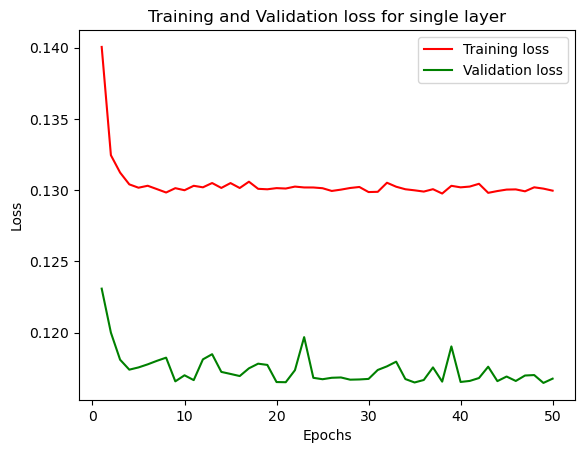

In [15]:
# plotting training and validation loss for single layer

loss = history_single_layer.history['loss']
val_loss = history_single_layer.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss for single layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



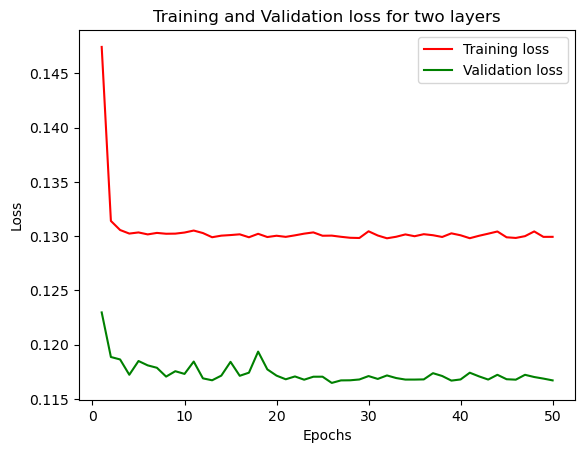

In [16]:
# plotting training and validation loss for two layers layer

loss = history_two_layers.history['loss']
val_loss = history_two_layers.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss for two layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [17]:
#Test result single layer
testResult_single_layer = single_layer_gru_model.evaluate(Xtest, Ytest)
print(testResult_single_layer)

17/17 [==============================] - 0s 8ms/step - loss: 0.1441 - mae: 0.1441
[0.14407964050769806, 0.14407964050769806]


In [18]:
#Test result two layer
testResult_two_layers = two_layers_gru_model.evaluate(Xtest, Ytest)
print(testResult_two_layers)

17/17 [==============================] - 0s 4ms/step - loss: 0.1436 - mae: 0.1436
[0.1435955911874771, 0.1435955911874771]
